# Load Libraries and Functions

In [12]:
# System, Data, Time, and Spec Libraries
import os
import pandas as pd
import time
import random
from datetime import datetime, timedelta
import numpy as np 
from line_profiler import LineProfiler  # Code peformance
profiler = LineProfiler()
import warnings
warnings.filterwarnings('ignore')
import csv
#pd.set_option('display.max_colwidth', None)
import multiprocess as mp
num_cores = mp.cpu_count()

# Data Visualization Libraries
import matplotlib.pyplot as plt
from tabulate import tabulate
import plotly.express as px
import seaborn as sns
#from pandas.io.json import json_normalize  # Older version
from pandas import json_normalize  # Newer version
from pandas.plotting import parallel_coordinates


# Natural Language Processing Libraries
import json
import requests
import xml.etree.ElementTree as ET
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import words
import string
import nltk
from collections import OrderedDict
from nltk.tokenize import word_tokenize
from pandas import json_normalize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.util import ngrams
from nltk.corpus import stopwords
from string import punctuation
punctuation = set(punctuation)
punctuation.update({'_', '-','‘'})
english_words = set(words.words())
from fuzzywuzzy import process
#nltk.download('words')
#nltk.download('punkt')
#nltk.download('stopwords')

# SQL Interface Libraries
import pymysql as mysql
import mysql.connector
import pyodbc
import sqlite3
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy import event
from string import punctuation

# Machine Learning Libraries
import scipy.stats as stats
from scipy.stats import zscore
from scipy.stats import yeojohnson
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder, PowerTransformer
from sklearn.impute import KNNImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay,roc_auc_score, roc_curve 
from sklearn.metrics import classification_report, mean_squared_error, f1_score
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from dmba import classificationSummary, AIC_score, BIC_score, plotDecisionTree,gainsChart
from scikitplot.metrics import plot_lift_curve, plot_cumulative_gain
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.metrics import specificity_score, sensitivity_score
from imblearn.under_sampling import RandomUnderSampler
from scikitplot.metrics import plot_lift_curve
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn import preprocessing
from sklearn import tree
from sklearn.model_selection import cross_val_score
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import KFold
from dmba import stepwise_selection, classificationSummary, backward_elimination
from sklearn.decomposition import PCA
from sklearn.utils.random import sample_without_replacement
from sklearn.metrics import precision_score, recall_score

# Importing Custom Functions
import nbimporter
from Functions import nan_info

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

# Test Join Outside of Database

In [4]:
# df1 = pd.read_csv('C://Users/halee/Downloads/events_table2024.csv')
# df2 = pd.read_csv('C://Users/halee/Downloads/drugs_table2024_prep.csv')
# # Merge df1 and df2
# merged_df1_df2 = pd.merge(df1, df2, on='event_id', how='inner')
# merged_df1_df2.drop(['patient_drug_id'], axis = 1, inplace = True)
# merged_df1_df2.drop_duplicates(inplace=True)
# merged_df1_df2.head(20)

ImportError: Pandas requires version '2021.07.0' or newer of 'fsspec' (version '0.9.0' currently installed).

In [5]:
nan_info(merged_df1_df2)

NameError: name 'merged_df1_df2' is not defined

In [6]:
merged_df1_df2['ndc9'] = merged_df1_df2['ndc9'].astype(str)
merged_df1_df2['ndc9'].head()

NameError: name 'merged_df1_df2' is not defined

In [7]:
with_drugs = merged_df1_df2[['event_id', 'expedited', 'age', 'sex', 'weight', 'report_source', 'ndc9', 'serious_outcome']].drop_duplicates(subset='event_id')

NameError: name 'merged_df1_df2' is not defined

In [244]:
with_drugs.head()

,event_id,expedited,age,sex,weight,report_source,ndc9,serious_outcome
0,1,1,39.0,2,112.00,1,502420040.0,1
55,2,1,57.0,1,74.00,1,502420040.0,1
83,3,2,44.0,2,61.22,1,9309224.0,1
86,4,1,65.0,2,57.00,3,502420135.0,1
97,5,1,42.0,2,50.00,3,502420135.0,1


In [245]:
with_drugs.to_csv('C://Users/halee/Downloads/with_drugs_sample2024.csv', index = False)

### SQL Password

In [15]:
PASSWORD  = 'PASSWORD' 

## Investigate number of records in each database table

In [16]:
connection = mysql.connector.connect(
    host="localhost", user="root", password=PASSWORD, database="pharma_db"
)

cursor = connection.cursor()
sql_query = """SELECT COUNT(*) FROM patient_reactions"""


cursor.execute(sql_query)
result = cursor.fetchall()
column_names = [i[0] for i in cursor.description]


result_query_df = pd.DataFrame(result, columns=column_names)

cursor.close()
connection.close()

result_query_df

,COUNT(*)
0,112551


# Get Dataset from SQL Database

In [70]:
# Connect to the MySQL server
connection = mysql.connector.connect(
    host="localhost", user="root", password=PASSWORD, database="pharma_db"
)

# Create a cursor object
cursor = connection.cursor()

In [15]:
# # Master Query from Data - goal

# master_query = """SELECT 
#                 a.serious_outcome,
#                 a.expedited,
#                 a.age,
#                 a.sex,
#                 a.year
#                 a.weight
#                 r.outcome,
#                 p.unit_price,
#                 p.generic_brand,
#                 l.ingredients,
#                 l.rxcui,
#                 l.set_id,
#                 d.manu_num,
#                 d.unii
#             FROM adverse_events a 
#                 INNER JOIN patients_reactions r ON a.event_id = r.event_id 
#                 INNER JOIN patients_drugs d ON r.event_id = d.event_id 
#                 INNER JOIN prices p ON d.ndc11 = p.ndc11
#                 INNER JOIN lables l ON p.ndc11 = l.ndc11
#             ORDER BY a.event_id DESC"""  # Still need to test and figure out

# Read in data from csv OR

In [17]:
master_query_df = pd.read_csv('DataLibrary/result_query_df.csv')

# option 2- Read in data from SQL

In [76]:
start_time = time.time()

connection = mysql.connector.connect(
    host="localhost", user="root", password=PASSWORD, database="pharma_db"
)

cursor = connection.cursor()
sql_query = """SELECT 
d.med_product,
d.event_id,
d.manu_num,
a.serious_outcome,
a.expedited,
a.age,
a.sex,
a.year,
a.weight,
r.outcome
FROM adverse_events a 

INNER JOIN patient_reactions r ON a.event_id = r.event_id
INNER JOIN patient_drugs d ON a.event_id = d.event_id
ORDER BY a.event_id DESC
"""
cursor.execute(sql_query)
result = cursor.fetchall()
column_names = [i[0] for i in cursor.description]
master_query_df = pd.DataFrame(result, columns=column_names)

cursor.close()
connection.close()


end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

master_query_df.head(10)


47.15399479866028


,med_product,event_id,manu_num,serious_outcome,expedited,age,sex,year,weight,outcome
0,['stelara'],24685,1,2,1,64,1,2024,72,Fatal
1,['stelara'],24685,1,2,1,64,1,2024,72,Fatal
2,['remicade'],24685,1,2,1,64,1,2024,72,Fatal
3,['cyclosporine'],24685,16,2,1,64,1,2024,72,Fatal
4,['efalizumab'],24685,0,2,1,64,1,2024,72,Fatal
5,['stelara'],24685,1,2,1,64,1,2024,72,Fatal
6,['stelara'],24685,1,2,1,64,1,2024,72,Fatal
7,['remicade'],24685,1,2,1,64,1,2024,72,Fatal
8,['cyclosporine'],24685,16,2,1,64,1,2024,72,Fatal
9,['efalizumab'],24685,0,2,1,64,1,2024,72,Fatal


In [26]:
master_query_df.shape

(99193, 11)

In [21]:
master_query_df.to_csv('DataLibrary/result_query_df.csv')

In [9]:
master_query_df = result_query_df.drop_duplicates()
master_query_df.shape

(99193, 12)

# Make dataset smaller for testing

# Preparation for Data Split

In [67]:
with_drugs = pd.read_csv('/Users/vicky/Downloads/with_drugs_sample2024.csv')

### Define numerical, text, and categorical variables

In [68]:
with_drugs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20885 entries, 0 to 20884
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   event_id         20885 non-null  int64  
 1   expedited        20885 non-null  int64  
 2   age              20885 non-null  float64
 3   sex              20885 non-null  int64  
 4   weight           20885 non-null  float64
 5   report_source    20885 non-null  int64  
 6   ndc9             18983 non-null  float64
 7   serious_outcome  20885 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 1.3 MB


In [69]:
result_query_df = with_drugs

In [88]:
cats = ['sex', 'expedited', 'report_source', 'ndc9']
nums = ['weight', 'age']  # Took out year since data will all be from recent 3 months of data 
all_vars = cats+nums

#Define outcome as categorical
result_query_df['serious_outcome'] = result_query_df['serious_outcome'].astype('category')

result_query_df.head()

,event_id,expedited,age,sex,weight,report_source,ndc9,serious_outcome
0,1,1,39.0,2,112.00,1,502420040.0,1
1,2,1,57.0,1,74.00,1,502420040.0,1
2,3,2,44.0,2,61.22,1,9309224.0,1
3,4,1,65.0,2,57.00,3,502420135.0,1
4,5,1,42.0,2,50.00,3,502420135.0,1


In [89]:
X_train.head()

,sex,expedited,report_source,weight,age,ndc9
868,1,1,1,70.0,32.000000,NaN
936,1,1,1,66.0,72.000000,726030344.0
4034,2,1,3,66.0,60.000000,647640800.0
1923,1,1,3,77.0,77.000000,476820456.0
3330,2,1,1,43.0,83.833333,31004500.0


### Create Transformation Pipeline

### One Hot Encode Drug Names for Full Dataset before Splitting - using NDC9 since there is only one per row

In [90]:
# need to do 


In [91]:
# # Create a categorical processing pipeline that uses one-hot encoding
# # Dropping binary columns and drop first of each level** NEED TO ADD**
# cat_pipe = Pipeline([('encoder', OneHotEncoder(drop='if_binary'))])

# # Create a numerical processing pipeline that uses skewness correction/center/scale.
# num_pipe = Pipeline([('skew_standardize', PowerTransformer())])

# # Create a text token processing step to vectorize tokens
# #text_pipe = Pipeline([('vector', tf_idf function())])

# # Combine pipeline steps
# all_pipe = ColumnTransformer(
#     transformers=[
#         ('cat', cat_pipe, cats),
#         ('num', num_pipe, nums)
#         # ('text', text_pipe, texts)  # Apply text pipeline if you have text columns
#     ],
#     verbose_feature_names_out=False
# )
# # Verify steps
# all_pipe

# Split Data into Training/Validation/Testing

### Make a Subset of the Dataset for Initial Model Training

In [92]:
master_query_df = result_query_df
master_query_df = master_query_df.head(5000)

In [93]:
# Split the data into features (X) and the target variable (y).
X = master_query_df[all_vars]

#Define outcome variable
y = master_query_df[['serious_outcome']]

#Split data
X_train, X_rest, y_train, y_rest = train_test_split(X, y, train_size=0.8, random_state = 2)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state = 2)

In [94]:
X_train.shape, y_train.shape

((4000, 6), (4000, 1))

In [95]:
y_train.value_counts()

serious_outcome
1                  3078
2                   542
0                   380
dtype: int64

In [77]:
X_val.shape, y_val.shape

((500, 6), (500, 1))

In [78]:
X_test.shape, y_test.shape

((500, 6), (500, 1))

## Encode Categorical Variables (other than drugs) & Standardize Numerical Variables

In [79]:
#Initialize encoders
encoder = OneHotEncoder(drop='if_binary', handle_unknown='ignore')
scaler = StandardScaler()

In [83]:
# Fit the encoder on X so all possible categories are captured, even if they are only in training or testing
encoder.fit(X_train[cats])
scaler.fit(X_train[nums])


StandardScaler()

In [113]:
#Initialize encoders
encoder = OneHotEncoder(drop='if_binary', sparse=False,handle_unknown='ignore')
scaler = StandardScaler()

# Fit the encoder on X so all possible categories are captured, even if they are only in training or testing
encoder.fit(X[cats])
scaler.fit(X_train[nums])


def transform_data(data):
    # Apply one-hot encoding to categorical features
    encoded_features = encoder.transform(data[cats])
    encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(cats))
    
    # Apply standardization to numerical features
    standardized_features = scaler.transform(data[nums])
    standardized_df = pd.DataFrame(standardized_features, columns=nums)
    
    # Concatenate the standardized numerical features with the encoded categorical features
    return pd.concat([data.drop(cats + nums, axis=1).reset_index(drop=True),
                      standardized_df.reset_index(drop=True),
                      encoded_df.reset_index(drop=True)], axis=1)

In [114]:
# Apply the transformation to all datasets
X_train_encoded = transform_data(X_train)
X_val_encoded = transform_data(X_val)
X_test_encoded = transform_data(X_test)
X_test_encoded.head()

,weight,age,sex_2,expedited_1,expedited_2,expedited_5,report_source_1,report_source_2,report_source_3,ndc9_203002.0,...,ndc9_7077101745.0,ndc9_7077101773.0,ndc9_7218700101.0,ndc9_7218700401.0,ndc9_7337200116.0,ndc9_7359409301.0,ndc9_7632901912.0,ndc9_7632908261.0,ndc9_8215400449.0,ndc9_nan
0,-1.414200,1.148318,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.689808,-1.529760,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.891028,-0.848067,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.764098,-1.870606,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.188834,0.758780,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Scale Numerical Only Since Sex already Binary (when using limited dataset, "no_drugs_sample) (already completed in encoding function)

In [115]:
# def transform_nums(data):
#     encoded_df = pd.DataFrame(scaler.fit_transform(data[nums]),
#                 columns = scaler.get_feature_names_out().tolist())
#     return pd.concat([encoded_df.reset_index(drop=True), data.drop(columns=nums).reset_index(drop=True)], axis=1)

# X_train_encoded = transform_nums(X_train_encoded)
# X_train_encoded.head()

# X_val_encoded = transform_nums(X_val_encoded)
# X_val_encoded.head()

# X_test_encoded = transform_nums(X_test_encoded)
# X_test_encoded.head()

In [108]:
#Fit pipeline to resampled data
#X_train_fit = all_pipe.fit_transform(X_train)
#Get feature names out from fit and create as new list

#def get_feature_names(column_transformer):
#    feature_names = []
#    for name, transformer, columns in column_transformer.transformers:
#        if hasattr(transformer, 'get_feature_names_out'):
#             feature_names.extend(transformer.get_feature_names_out())
#         else:
#             feature_names.extend(columns)  # Use original columns if transformer does not provide feature names
#     return feature_names

# # Extract feature names
# feature_names = get_feature_names(all_pipe)


# #X_train_cols = X_train_fit.get_feature_names_out().tolist()
# X_train_pipe = pd.DataFrame(all_pipe.fit_transform(X_train), columns = X_train_cols)

In [27]:
# #Apply pipeline to all of X
# X_test_fit = all_pipe.fit(X_test)
# #Get feature names out from fit and create as new list
# # X_test_cols = X_test_fit.get_feature_names_out().tolist()
# X_test_pipe = pd.DataFrame(all_pipe.fit_transform(X_test), columns = X_cols)

In [28]:
# #Apply pipeline to all of X
# X_val_fit = all_pipe.fit(X_val)
# #Get feature names out from fit and create as new list
# X_val_cols = X_val_fit.get_feature_names_out().tolist()
# X_val_pipe = pd.DataFrame(all_pipe.fit_transform(X_val), columns = X_cols)

## Resampling Techniques - UnderSampling

In [122]:
y_train.value_counts()

serious_outcome
1                  3078
2                   542
0                   380
dtype: int64

In [123]:
# Create a RandomUnderSampler instance with a specified random seed and sampling strategy
# Define the sampling strategy to balance all classes
sampling_n = {0: y_train.value_counts()[0], 1: y_train.value_counts()[0], 2: y_train.value_counts()[0]}
rus = RandomUnderSampler(random_state = 1, sampling_strategy=sampling_n )

# Perform random under-sampling on the training dataset
X_train_under, y_train_under = rus.fit_resample(X_train_encoded, y_train)

In [124]:
X_train_under.shape, y_train_under.shape

((1140, 648), (1140, 1))

In [125]:
y_train_under.value_counts()

serious_outcome
0                  380
1                  380
2                  380
dtype: int64

# Multiclass Classification Model Training

#### Evalutation Metrics Function

In [126]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Image
import os

def evaluate_model(model, X_test, y_test, labels, model_name):

    # Predict on the test data
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average=None, labels=labels)
    recall = recall_score(y_test, y_pred, average=None, labels=labels)
    f1 = f1_score(y_test, y_pred, average=None, labels=labels)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    
    # Calculate specificity for each class
    specificity = np.array([
        (np.sum(cm) - np.sum(cm[:, i]) - np.sum(cm[i, :]) + cm[i, i]) / (np.sum(cm) - np.sum(cm[:, i]))
        for i in range(len(labels))
    ])
    
    # Round metrics to three decimal places
    accuracy = round(accuracy, 3)
    precision = np.round(precision, 3)
    recall = np.round(recall, 3)
    f1 = np.round(f1, 3)
    specificity = np.round(specificity, 3)
    
    # Prepare data for DataFrame
    rows = []
    for i, label in enumerate(labels):
        rows.append({
            'model': model_name,
            'class': label,
            'accuracy': accuracy,
            'precision': precision[i],
            'recall': recall[i],
            'f1_score': f1[i],
            'specificity': specificity[i]
        })
    
    # Create DataFrame
    metrics_df = pd.DataFrame(rows)
    
    # Create the ConfusionMatrices directory if it does not exist
    folder_path = 'ClassificationMatrices'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    # Store the confusion matrix heatmap image
    img_path = os.path.join(folder_path, f'confusion_matrix_{model_name}.png')
    
    # Define axis labels
    axis_labels = ['Not Serious', 'Serious', 'Death']  # Replace with actual labels if different
    
    # Create the heatmap
    plt.figure(figsize=(6, 4))
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                     xticklabels=axis_labels, yticklabels=axis_labels,
                     annot_kws={"size": 11})
    
    # Set labels and title with larger font sizes
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.title(f'Classification Matrix Heatmap for {model_name}', fontsize=16)
    
    # Adjust the size of the tick labels
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)  # Adjust x-tick labels font size
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)  # Adjust y-tick labels font size
    
    plt.tight_layout()
    
    # Save the plot to an image file
    plt.savefig(img_path)
    plt.close()  # Close the plot to free up memory
    
    return metrics_df, img_path, y_pred


## White Box Models

### Logistic Regression L1 Regularization

#### Generate and Fit Model on Training Data

In [127]:
log_l1 = LogisticRegression(solver='saga', penalty='l1', random_state=1)
log_l1.fit(X_train_under, y_train_under)

LogisticRegression(penalty='l1', random_state=1, solver='saga')

#### Fit Model on Testing Data, Model Performance Metrics

In [128]:
model_name = 'log_l1'

# Run model on test data, generate confusion matrix, save y_pred
log_l1_metrics_df, log_l1_img_path, log_l1_y_pred = evaluate_model(log_l1, X_test_encoded, y_test, labels=[0, 1, 2], model_name=model_name)

log_l1_metrics_df.head()

,model,class,accuracy,precision,recall,f1_score,specificity
0,log_l1,0,0.612,0.644,0.884,0.745,0.989
1,log_l1,1,0.612,0.894,0.569,0.695,0.349
2,log_l1,2,0.612,0.250,0.681,0.366,0.924


#### View Classification Matrix

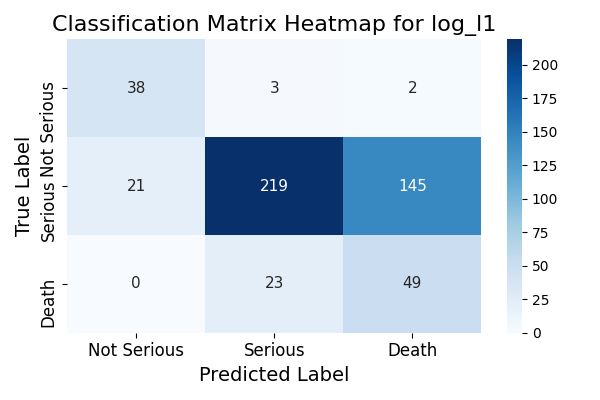

In [129]:
display(Image(filename=log_l1_img_path))

#### Other Model Metrics - Model Coefficient Odds for Each Outcome

In [130]:
def get_model_coefficients_and_odds(data, model_name, top_n=5):
    outcomes = ['Non-Serious', 'Serious', 'Death']
    result = {}

    for i, outcome in enumerate(outcomes):
        # Intercept
        intercept_data = {'Feature': ['Intercept'], 'LogOdds': [model_name.intercept_[i]]}
        intercept_df = pd.DataFrame(intercept_data)
        intercept_df['Odds'] = np.exp(intercept_df['LogOdds'])

        # Coefficients
        coef_data = {'Feature': data.columns, 'LogOdds': model_name.coef_[i]}
        coef_df = pd.DataFrame(coef_data)
        coef_df = coef_df.reindex(coef_df['LogOdds'].abs().sort_values(ascending=False).index)
        coef_df['Odds'] = np.exp(coef_df['LogOdds'])

        # Combine intercept and coefficients
        df = pd.concat([intercept_df, coef_df])
        
        result[outcome] = df.head(top_n + 1)

    return result

In [131]:
coefficients_and_odds = get_model_coefficients_and_odds(X_train_under, log_l1)
for outcome, df in coefficients_and_odds.items():
     print(f"Top features for {outcome}:")
     print(df)

Top features for Non-Serious:
              Feature   LogOdds       Odds
0           Intercept  1.004382   2.730219
282  ndc9_502420150.0  4.029775  56.248258
3         expedited_1 -3.630193   0.026511
28      ndc9_605363.0  3.009363  20.274472
9       ndc9_203002.0  2.895314  18.089186
533  ndc9_722870310.0  2.725934  15.270677
Top features for Serious:
               Feature   LogOdds      Odds
0            Intercept -0.357553  0.699386
80      ndc9_7400561.0 -2.094542  0.123127
62      ndc9_6900238.0  1.457064  4.293334
511   ndc9_702550025.0  1.045244  2.844092
626  ndc9_6980000250.0  0.819278  2.268862
16       ndc9_302327.0  0.759217  2.136603
Top features for Death:
              Feature   LogOdds      Odds
0           Intercept -0.646829  0.523704
340  ndc9_578940030.0 -1.759567  0.172119
282  ndc9_502420150.0 -1.569076  0.208237
579  ndc9_834570124.0  1.554655  4.733453
104    ndc9_7800846.0  1.391587  4.021226
284  ndc9_502420917.0  1.206680  3.342370


### Logistic Regression L2 Regularization

#### Generate and Fit Model on Training Data

In [132]:
log_l2 = LogisticRegression(solver='saga', penalty='l2', random_state=1)
log_l2.fit(X_train_under, y_train_under)

LogisticRegression(random_state=1, solver='saga')

#### Fit Model on Testing Data, Model Performance Metrics

In [133]:
model_name = 'log_l2'

# Run model on test data, generate confusion matrix, save y_pred
log_l2_metrics_df, log_l2_img_path, log_l2_y_pred = evaluate_model(log_l2, X_test_encoded, y_test, labels=[0, 1, 2], model_name=model_name)

log_l2_metrics_df.head()

,model,class,accuracy,precision,recall,f1_score,specificity
0,log_l2,0,0.616,0.644,0.884,0.745,0.989
1,log_l2,1,0.616,0.885,0.579,0.700,0.347
2,log_l2,2,0.616,0.249,0.653,0.360,0.920


#### View Classification Matrix

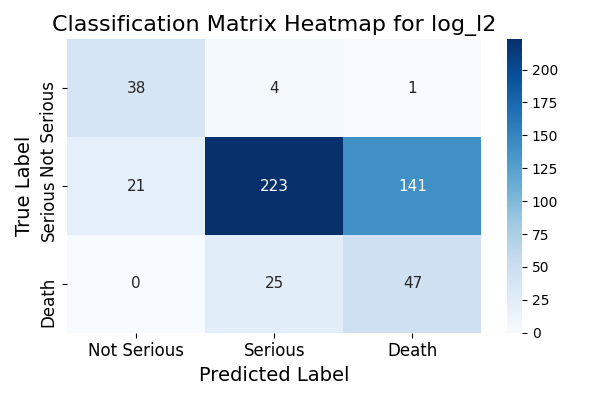

In [134]:
display(Image(filename=log_l2_img_path))

#### Other Metrics - Model Coefficient Odds for Each Outcome

In [135]:
coefficients_and_odds = get_model_coefficients_and_odds(X_train_under, log_l2)
for outcome, df in coefficients_and_odds.items():
     print(f"Top features for {outcome}:")
     print(df)

Top features for Non-Serious:
              Feature   LogOdds       Odds
0           Intercept  0.574917   1.776982
282  ndc9_502420150.0  2.831991  16.979238
3         expedited_1 -2.271501   0.103157
28      ndc9_605363.0  1.792947   6.007127
9       ndc9_203002.0  1.739824   5.696338
533  ndc9_722870310.0  1.658627   5.252092
Top features for Serious:
               Feature   LogOdds      Odds
0            Intercept -0.252911  0.776537
80      ndc9_7400561.0 -1.402853  0.245894
62      ndc9_6900238.0  1.077050  2.936005
511   ndc9_702550025.0  1.007067  2.737561
3          expedited_1  0.965122  2.625107
626  ndc9_6980000250.0  0.932080  2.539787
Top features for Death:
              Feature   LogOdds      Odds
0           Intercept -0.322005  0.724694
282  ndc9_502420150.0 -1.928269  0.145400
3         expedited_1  1.306380  3.692780
340  ndc9_578940030.0 -1.262381  0.282979
104    ndc9_7800846.0  1.133334  3.105996
4         expedited_2 -1.076784  0.340689


### Logistic Regression Elastic Net

#### Grid Search

In [136]:
param_grid = {
    'l1_ratio': [i / 9 for i in range(10)],  # 10 values from 0 to 1 (0, 0.1, 0.2, ..., 1.0)
    'C': [0.01, 0.1, 1, 10, 100]  # Different strengths of regularization
}

# Initialize the Logistic Regression model with Elastic Net penalty
log_reg_elasticnet = LogisticRegression(
    penalty='elasticnet',  # Use Elastic Net regularization
    solver='saga',        # Solver that supports Elastic Net
    random_state=1
)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=log_reg_elasticnet,
    param_grid=param_grid,
    scoring='accuracy',   # Or another metric of choice
    cv=5,                 # Number of cross-validation folds
    n_jobs=-1              # Use all available CPUs
)

# Fit GridSearchCV to the training data
grid_search.fit(X_train_under, y_train_under.values.ravel())

# Extract and print the best parameters and best score from grid search
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

best_score = grid_search.best_score_
print(f"Best cross-validation score: {best_score:.3f}")

# Get the best model
elastic_net = grid_search.best_estimator_


Best parameters: {'C': 10, 'l1_ratio': 0.5555555555555556}
Best cross-validation score: 0.714


#### Generate and Fit Model on Training Data

In [137]:
elastic_net.fit(X_train_under, y_train_under)

LogisticRegression(C=10, l1_ratio=0.5555555555555556, penalty='elasticnet',
                   random_state=1, solver='saga')

#### Fit Model on Testing Data, Model Performance Metrics

In [138]:
model_name = 'elastic_net'

# Run model on test data, generate confusion matrix, save y_pred
elastic_net_metrics_df, elastic_net_img_path, elastic_net_y_pred = evaluate_model(elastic_net, X_test_encoded, y_test, labels=[0, 1, 2], model_name=model_name)

elastic_net_metrics_df.head()

,model,class,accuracy,precision,recall,f1_score,specificity
0,elastic_net,0,0.618,0.623,0.884,0.731,0.989
1,elastic_net,1,0.618,0.892,0.577,0.700,0.351
2,elastic_net,2,0.618,0.258,0.681,0.374,0.926


#### View Classification Matrix

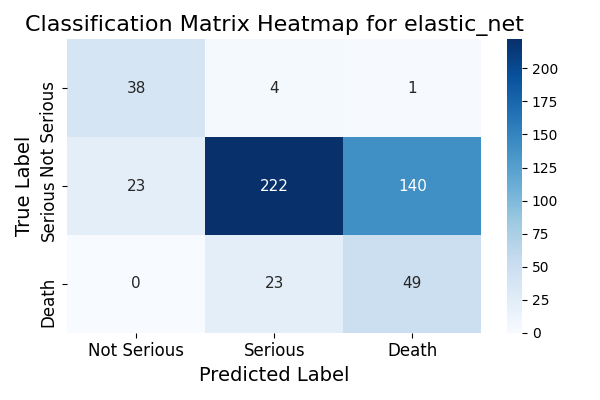

In [139]:
display(Image(filename=elastic_net_img_path))

#### Other Metrics - Model Coefficient Odds for Each Outcome

In [140]:
coefficients_and_odds = get_model_coefficients_and_odds(X_train_under, elastic_net)
for outcome, df in coefficients_and_odds.items():
     print(f"Top features for {outcome}:")
     print(df)

Top features for Non-Serious:
              Feature   LogOdds       Odds
0           Intercept  0.678076   1.970083
282  ndc9_502420150.0  3.574628  35.681341
28      ndc9_605363.0  3.256789  25.966028
533  ndc9_722870310.0  3.157781  23.518349
9       ndc9_203002.0  2.905685  18.277753
3         expedited_1 -2.816891   0.059792
Top features for Serious:
               Feature   LogOdds      Odds
0            Intercept -0.274903  0.759646
80      ndc9_7400561.0 -2.118693  0.120189
597  ndc9_5846800225.0  1.847978  6.346973
511   ndc9_702550025.0  1.779328  5.925875
62      ndc9_6900238.0  1.534101  4.637156
28       ndc9_605363.0 -1.522516  0.218162
Top features for Death:
              Feature   LogOdds      Odds
0           Intercept -0.403173  0.668197
282  ndc9_502420150.0 -2.604698  0.073925
340  ndc9_578940030.0 -2.318540  0.098417
559  ndc9_760750101.0  2.028587  7.603336
104    ndc9_7800846.0  1.958965  7.091980
9       ndc9_203002.0 -1.734496  0.176489


### Single Decision Tree

#### Grid Search

In [143]:
# Define a grid of hyperparameters to search for in tree
param_grid = {
    'max_depth' : [5,6,7,8,9,10],
    'min_samples_leaf' : [1,2,3,4,5,6]
    
}
# Create a GridSearchCV object using and the defined parameter grid
tree1_search = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=10, n_jobs=-1)

# Fit the GridSearchCV to the balanced training data to find the best hyperparameters
tree1_search.fit(X_train_under, y_train_under.values.ravel())

# Get the best hyperparameters found by the GridSearch
best_params = tree1_search.best_params_
print(f"Best parameters: {best_params}")

tree1 = tree1_search.best_estimator_


Best parameters: {'max_depth': 10, 'min_samples_leaf': 6}


#### Generate and Fit Model on Training Data

In [144]:
tree1.fit(X_train_under, y_train_under)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=6, random_state=1)

#### Fit Model on Testing Data, Model Performance Metrics

In [145]:
model_name = 'tree1'

# Run model on test data, generate confusion matrix, save y_pred
tree1_metrics_df, tree1_img_path, tree1_y_pred = evaluate_model(tree1, X_test_encoded, y_test, labels=[0, 1, 2], model_name=model_name)

tree1_metrics_df.head()

,model,class,accuracy,precision,recall,f1_score,specificity
0,tree1,0,0.612,0.667,0.884,0.760,0.989
1,tree1,1,0.612,0.891,0.574,0.698,0.349
2,tree1,2,0.612,0.241,0.653,0.352,0.918


#### View Classification Matrix

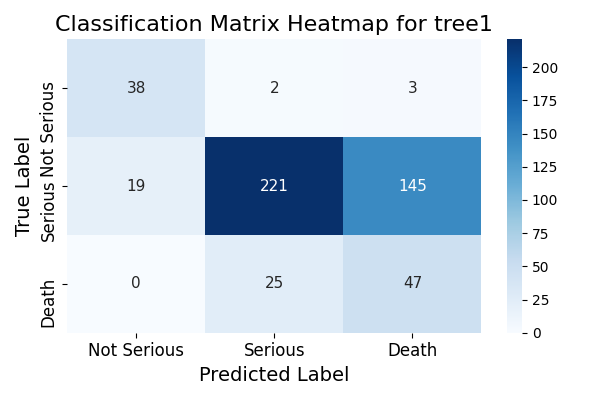

In [146]:
display(Image(filename=tree1_img_path))

#### Other Metrics - Feature Importance and Tree Structure

In [160]:
# Feature Importance Scores
# Extract feature importances
importances = tree1.feature_importances_
features = X_train_under.columns

# Create a DataFrame for better plotting
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 8))
bars = plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Plot for DecisionTreeClassifier')
plt.gca().invert_yaxis()  # To display the most important feature at the top
# Add labels to the bars
for bar in bars:
    plt.text(
        bar.get_width(),
        bar.get_y() + bar.get_height() / 2,
        f'{bar.get_width():.4f}',
        va='center'
    )

plt.show()

In [161]:
from sklearn.tree import plot_tree
# Plot the tree structure
plt.figure(figsize=(20, 10))
plot_tree(tree1, filled=True, feature_names=X_train_under.columns, class_names=['NonSerious', 'Serious', 'Death'], rounded=True)
plt.title('Decision Tree Structure')
plt.show()

In [166]:
#Plot max_depth = 2
from sklearn.tree import plot_tree
folder_path = 'ModelOutput'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    
img_path = os.path.join(folder_path, 'tree1_maxdepth2.png')

# Plot the tree structure
plt.figure(figsize=(20, 10))
plot_tree(tree1, filled=True,max_depth=2, feature_names=X_train_under.columns, class_names=['NonSerious', 'Serious', 'Death'], rounded=True)
plt.title('Decision Tree Structure')
plt.show()
plt.savefig(img_path)

In [167]:
#Plot max_depth = 1
from sklearn.tree import plot_tree
folder_path = 'ModelOutput'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    
img_path = os.path.join(folder_path, 'tree1_maxdepth1.png')

# Plot the tree structure
plt.figure(figsize=(20, 10))
plot_tree(tree1, filled=True,max_depth=1, feature_names=X_train_under.columns, class_names=['NonSerious', 'Serious', 'Death'], rounded=True)
plt.title('Decision Tree Structure')
plt.show()
plt.savefig(img_path)

## Ensembles

### Random Forest Classifier w/ 10-k CV

#### Grid Search

In [168]:
param_grid = {
    'n_estimators': [100, 125, 150, 175, 200]  # Example range for number of estimators
}

# Initialize the Random Forest Classifier
random_forest = RandomForestClassifier(random_state=1)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=random_forest,
                           param_grid=param_grid,
                           cv=5,  # Number of cross-validation folds
                           scoring='accuracy',  # Use accuracy as the scoring metric
                           n_jobs=-1,  # Use all available cores
                           verbose=2)  # Print progress messages

# Fit GridSearchCV to the data
grid_search.fit(X_train_under, y_train_under.values.ravel())

# Get the best model from the grid search
rf = grid_search.best_estimator_

rf.fit(X_train_under, y_train_under)

# Print the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Example: Printing the best model parameters
print("Best Random Forest Model:")
print(rf)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Parameters: {'n_estimators': 175}
Best Score: 0.7289473684210527
Best Random Forest Model:
RandomForestClassifier(n_estimators=175, random_state=1)


#### Fit Model on Testing Data, Model Performance Metrics

In [169]:
model_name = 'rf'

# Run model on test data, generate confusion matrix, save y_pred
rf_metrics_df, rf_img_path, rf_y_pred = evaluate_model(rf, X_test_encoded, y_test, labels=[0, 1, 2], model_name=model_name)

rf_metrics_df.head()

,model,class,accuracy,precision,recall,f1_score,specificity
0,rf,0,0.62,0.587,0.860,0.698,0.986
1,rf,1,0.62,0.896,0.584,0.708,0.357
2,rf,2,0.62,0.258,0.667,0.372,0.924


#### View Classification Matrix

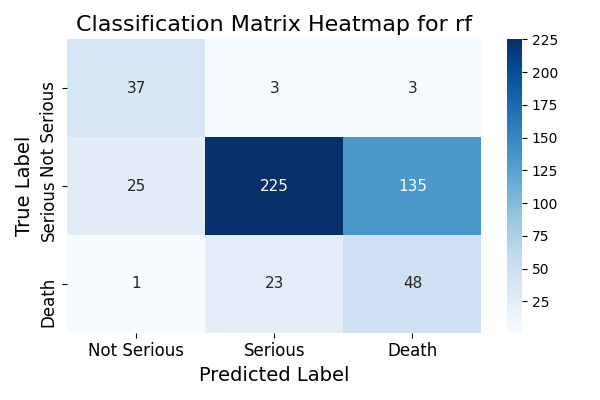

In [170]:
display(Image(filename=rf_img_path))

#### Other Metrics

In [171]:
# Get feature importance scores
importances=rf.feature_importances_
feature_importance_pairs=list(zip(X_train_under.columns, importances))

# Sort in descending order
sorted_feature_importance_pairs = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)

# Print scores
print("Feature Importance Scores")
for feature, importance in sorted_feature_importance_pairs:
     print(f"{feature}: {importance:.4f}")

Feature Importance Scores
age: 0.1358
weight: 0.1348
expedited_1: 0.1164
expedited_2: 0.1051
ndc9_502420150.0: 0.0640
ndc9_2405911.0: 0.0326
sex_2: 0.0195
report_source_1: 0.0134
ndc9_nan: 0.0111
ndc9_6980000250.0: 0.0108
ndc9_7400561.0: 0.0084
report_source_3: 0.0080
ndc9_6900238.0: 0.0076
ndc9_603026.0: 0.0068
ndc9_834570124.0: 0.0067
ndc9_502420917.0: 0.0062
ndc9_203002.0: 0.0061
ndc9_7800846.0: 0.0048
ndc9_605363.0: 0.0048
ndc9_302327.0: 0.0046
ndc9_647640107.0: 0.0044
ndc9_6900187.0: 0.0043
ndc9_578940030.0: 0.0042
ndc9_722870310.0: 0.0041
report_source_2: 0.0041
ndc9_303734.0: 0.0040
ndc9_6050506282.0: 0.0040
ndc9_688170134.0: 0.0040
ndc9_7800639.0: 0.0038
ndc9_595720402.0: 0.0036
ndc9_6900501.0: 0.0035
ndc9_7800860.0: 0.0032
ndc9_6887500101.0: 0.0031
expedited_5: 0.0029
ndc9_511440020.0: 0.0029
ndc9_702550025.0: 0.0028
ndc9_578940449.0: 0.0028
ndc9_22801410.0: 0.0028
ndc9_502420135.0: 0.0027
ndc9_649800449.0: 0.0027
ndc9_167290034.0: 0.0027
ndc9_695390011.0: 0.0026
ndc9_50242006

### Gradient Boosted Tree w/ 10-k CV

#### Grid Search

In [172]:
# Define a grid of hyperparameters to search for in the Gradient Boosting Classifier
param_grid = {
    'max_depth' : [5,6,7,8,9,10],
    'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 1],
    'n_estimators' : [50,75,100,125,150],
}
# Create a GridSearchCV object using GradientBoostingClassifier and the defined parameter grid
tree_search = GridSearchCV(GradientBoostingClassifier(random_state=1), param_grid, cv=10, n_jobs=-1)
# Fit the GridSearchCV to the balanced training data to find the best hyperparameters
tree_search.fit(X_train_under, y_train_under.values.ravel())
# Get the best hyperparameters found by the GridSearch
tree_search.best_params_

grboost = tree_search.best_estimator_


# Print the best parameters and the best score
print("Best Parameters:", tree_search.best_params_)
print("Best Score:", tree_search.best_score_)

# Example: Printing the best model parameters
print("Best Gradient Boosted Tree:")
print(grboost)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 125}
Best Score: 0.7464912280701755
Best Gradient Boosted Tree:
GradientBoostingClassifier(max_depth=10, n_estimators=125, random_state=1)


#### Fit Model on Testing Data, Model Performance Metrics

In [173]:
model_name = 'grboost'

# Run model on test data, generate confusion matrix, save y_pred
grboost_metrics_df, grboost_img_path, grboost_y_pred = evaluate_model(grboost, X_test_encoded, y_test, labels=[0, 1, 2], model_name=model_name)

grboost_metrics_df.head()

,model,class,accuracy,precision,recall,f1_score,specificity
0,grboost,0,0.64,0.529,0.837,0.649,0.984
1,grboost,1,0.64,0.876,0.626,0.730,0.360
2,grboost,2,0.64,0.274,0.597,0.376,0.915


#### View Classification Matrix

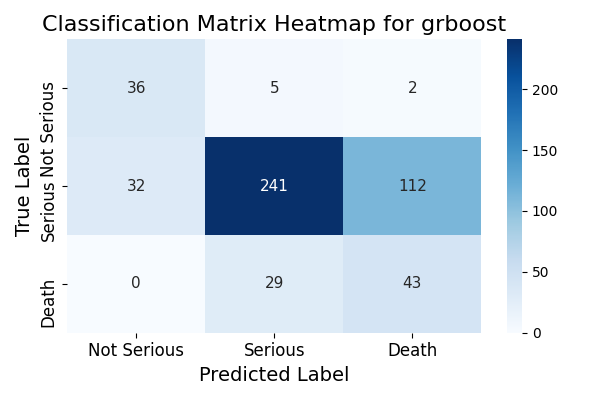

In [175]:
display(Image(filename=grboost_img_path))

#### Other Metrics

In [176]:
# Get feature importance scores
importances=grboost.feature_importances_
feature_importance_pairs=list(zip(X_train_under.columns, importances))

# Sort in descending order
sorted_feature_importance_pairs = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)

# Print scores
print("Feature Importance Scores")
for feature, importance in sorted_feature_importance_pairs:
     print(f"{feature}: {importance:.4f}")

Feature Importance Scores
expedited_1: 0.3170
weight: 0.1567
ndc9_502420150.0: 0.1283
age: 0.1064
sex_2: 0.0160
ndc9_7400561.0: 0.0122
ndc9_203002.0: 0.0100
ndc9_6980000250.0: 0.0086
ndc9_nan: 0.0085
ndc9_605363.0: 0.0078
ndc9_722870310.0: 0.0065
ndc9_6900238.0: 0.0058
ndc9_302327.0: 0.0057
report_source_1: 0.0057
ndc9_502420917.0: 0.0048
ndc9_834570124.0: 0.0048
report_source_3: 0.0047
ndc9_702550025.0: 0.0042
ndc9_7800846.0: 0.0040
ndc9_603026.0: 0.0035
ndc9_688170134.0: 0.0034
ndc9_649800449.0: 0.0033
report_source_2: 0.0033
ndc9_22801410.0: 0.0032
ndc9_578940449.0: 0.0032
ndc9_782060147.0: 0.0029
ndc9_684620226.0: 0.0029
ndc9_560620327.0: 0.0028
ndc9_760750101.0: 0.0028
ndc9_7800639.0: 0.0028
ndc9_5846800225.0: 0.0028
ndc9_578940030.0: 0.0026
ndc9_101220210.0: 0.0026
ndc9_644060101.0: 0.0025
ndc9_167290048.0: 0.0025
ndc9_621350752.0: 0.0024
ndc9_621350772.0: 0.0024
ndc9_690970897.0: 0.0024
ndc9_511440050.0: 0.0024
ndc9_595720711.0: 0.0023
ndc9_16907703.0: 0.0023
ndc9_462870035.0: 0

## Non-parametric

### K-Nearest Neighbors Classifier

#### Grid Search

In [177]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]  # Example range for number of neighbors
}

# Initialize the K-Nearest Neighbors Classifier
knn = KNeighborsClassifier()

# Initialize GridSearchCV
grid_search_knn = GridSearchCV(estimator=knn,
                               param_grid=param_grid,
                               cv=5,  # Number of cross-validation folds
                               scoring='accuracy',  # Use accuracy as the scoring metric
                               n_jobs=-1,  # Use all available cores
                               verbose=2)  # Print progress messages

# Fit GridSearchCV to the data
grid_search_knn.fit(X_train_under, y_train_under.values.ravel())

# Get the best model from the grid search
knn = grid_search_knn.best_estimator_

# Print the best parameters and the best score
print("Best Parameters for KNN:", grid_search_knn.best_params_)
print("Best Score for KNN:", grid_search_knn.best_score_)

# Example: Printing the best model parameters
print("Best KNN Model:")
print(knn)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
Best Parameters for KNN: {'n_neighbors': 5}
Best Score for KNN: 0.6903508771929825
Best KNN Model:
KNeighborsClassifier()


#### Fit Model on Testing Data, Model Performance Metrics

In [178]:
model_name = 'knn'

# Run model on test data, generate confusion matrix, save y_pred
knn_metrics_df, knn_img_path, knn_y_pred = evaluate_model(knn, X_test_encoded, y_test, labels=[0, 1, 2], model_name=model_name)

knn_metrics_df.head()

,model,class,accuracy,precision,recall,f1_score,specificity
0,knn,0,0.558,0.328,0.907,0.481,0.990
1,knn,1,0.558,0.897,0.499,0.641,0.325
2,knn,2,0.558,0.287,0.667,0.402,0.928


#### View Classification Matrix

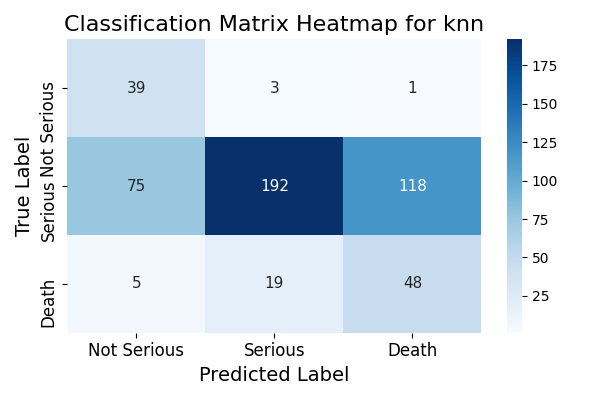

In [179]:
display(Image(filename=knn_img_path))

#### Other Metrics

### Neural Network

In [180]:
# train

In [181]:
# feature importance

In [182]:
# 

### Baseline

In [228]:
from sklearn.dummy import DummyClassifier

baseline_model = DummyClassifier(strategy='most_frequent')
baseline_model.fit(X_test_encoded, y_test)
baseline_metrics_df, baseline_img_path, _ = evaluate_model(
    baseline_model, X_test_encoded, y_test, labels=[0, 1, 2], model_name='Baseline'
)
baseline_metrics_df

,model,class,accuracy,precision,recall,f1_score,specificity
0,Baseline,0,0.77,0.00,0.0,0.00,0.914
1,Baseline,1,0.77,0.77,1.0,0.87,NaN
2,Baseline,2,0.77,0.00,0.0,0.00,0.856


# Performance Metrics Table

In [246]:
def display_model_metrics_table(metrics_dfs):
    # Concatenate all DataFrames
    combined_df = pd.concat(metrics_dfs, ignore_index=True)
    
    # Convert DataFrame to a list of lists for tabulate
    table = combined_df.values.tolist()
    
    # Get column headers from DataFrame
    headers = combined_df.columns.tolist()
    
    # Generate and print the table
    table_str = tabulate(table, headers, tablefmt='pretty')
    print(table_str)
    return combined_df

model_metrics = display_model_metrics_table([baseline_metrics_df,log_l1_metrics_df, log_l2_metrics_df, elastic_net_metrics_df,
                           tree1_metrics_df, rf_metrics_df, knn_metrics_df])  # grboost_metrics_df

+-------------+-------+----------+-----------+--------+----------+-------------+
|    model    | class | accuracy | precision | recall | f1_score | specificity |
+-------------+-------+----------+-----------+--------+----------+-------------+
|  Baseline   |   0   |   0.77   |    0.0    |  0.0   |   0.0    |    0.914    |
|  Baseline   |   1   |   0.77   |   0.77    |  1.0   |   0.87   |     nan     |
|  Baseline   |   2   |   0.77   |    0.0    |  0.0   |   0.0    |    0.856    |
|   log_l1    |   0   |  0.612   |   0.644   | 0.884  |  0.745   |    0.989    |
|   log_l1    |   1   |  0.612   |   0.894   | 0.569  |  0.695   |    0.349    |
|   log_l1    |   2   |  0.612   |   0.25    | 0.681  |  0.366   |    0.924    |
|   log_l2    |   0   |  0.616   |   0.644   | 0.884  |  0.745   |    0.989    |
|   log_l2    |   1   |  0.616   |   0.885   | 0.579  |   0.7    |    0.347    |
|   log_l2    |   2   |  0.616   |   0.249   | 0.653  |   0.36   |    0.92     |
| elastic_net |   0   |  0.6

### Show Class Outcomes more Cleanly for Paper

Saves as csv, that can copy paste into the Excel file within the same folder. This makes it easy to paste the values into the paper

In [247]:

def format_as_percentage(df):
    # Format metrics as percentage with one decimal point
 #   df['accuracy'] = df['accuracy'].apply(lambda x: f"{x * 100:.1f}%")
    df['precision'] = df['precision'].apply(lambda x: f"{x * 100:.1f}%")
    df['recall'] = df['recall'].apply(lambda x: f"{x * 100:.1f}%")
    df['specificity'] = df['specificity'].apply(lambda x: f"{x * 100:.1f}%")
    df['f1_score'] = df['f1_score'].apply(lambda x: f"{x * 100:.1f}%")
    return df

model_metrics = format_as_percentage(model_metrics)

def aggregate_metrics(df):
    # Group by 'model'
    grouped = df.groupby('model').agg({
        'accuracy': 'mean',  # Average accuracy
        'precision': lambda x: x.tolist(),  # List of precision values
        'recall': lambda x: x.tolist(),  # List of recall values
        'specificity': lambda x: x.tolist(),  # List of specificity values
        'f1_score': lambda x: x.tolist()  # List of F1 scores
    }).reset_index()
    
    return grouped

# Apply aggregation function
aggregated_df = aggregate_metrics(model_metrics)




# Rename columns
aggregated_df = aggregated_df.rename(columns={
  #  'model': 'Model',
    'accuracy': 'Accuracy',
    'precision': 'Precision (class 0,1,2)',
    'recall': 'Recall (class 0,1,2)',
    'f1_score': 'F-score (class 0,1,2)',
    'specificity': 'Specificity (class 0,1,2)'
})


# Rename values in 'model' column
aggregated_df['model'] = aggregated_df['model'].replace({
    'elastic_net': 'Elastic Net',
    'knn': 'KNN',
    'tree1': 'Decision Tree',
    'log_l1': 'Lasso Regression',
    'log_l2': 'Ridge Regression',
    'rf': 'Random Forest'
    
})

aggregated_df['Accuracy'] = aggregated_df['Accuracy'] .apply(lambda x: f"{x * 100:.1f}%")

# Display the resulting DataFrame
print(aggregated_df)

#Save it as a CSV
folder_path = 'ModelOutput'
file_path = os.path.join(folder_path, 'aggregated_metrics.csv')
aggregated_df.to_csv(file_path, index=False)


              model Accuracy Precision (class 0,1,2)   Recall (class 0,1,2)  \
0          Baseline    77.0%     [0.0%, 77.0%, 0.0%]   [0.0%, 100.0%, 0.0%]   
1       Elastic Net    61.8%   [62.3%, 89.2%, 25.8%]  [88.4%, 57.7%, 68.1%]   
2               KNN    55.8%   [32.8%, 89.7%, 28.7%]  [90.7%, 49.9%, 66.7%]   
3  Lasso Regression    61.2%   [64.4%, 89.4%, 25.0%]  [88.4%, 56.9%, 68.1%]   
4  Ridge Regression    61.6%   [64.4%, 88.5%, 24.9%]  [88.4%, 57.9%, 65.3%]   
5     Random Forest    62.0%   [58.7%, 89.6%, 25.8%]  [86.0%, 58.4%, 66.7%]   
6     Decision Tree    61.2%   [66.7%, 89.1%, 24.1%]  [88.4%, 57.4%, 65.3%]   

  Specificity (class 0,1,2)  F-score (class 0,1,2)  
0      [91.4%, nan%, 85.6%]    [0.0%, 87.0%, 0.0%]  
1     [98.9%, 35.1%, 92.6%]  [73.1%, 70.0%, 37.4%]  
2     [99.0%, 32.5%, 92.8%]  [48.1%, 64.1%, 40.2%]  
3     [98.9%, 34.9%, 92.4%]  [74.5%, 69.5%, 36.6%]  
4     [98.9%, 34.7%, 92.0%]  [74.5%, 70.0%, 36.0%]  
5     [98.6%, 35.7%, 92.4%]  [69.8%, 70.8%, 37.2%